In [1]:
# Load and preview the provided datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from pprint import pprint
import re
import math
from datetime import datetime
from shapely.wkt import loads as load_wkt
from shapely.geometry import MultiLineString, LineString, Point
from shapely.ops import unary_union

In [2]:
paths = {
    "school_buses": "datasets/ACT_School_Bus_Services.csv",
    "population_proj": "datasets/ACT-Population-Projections-2022-2060-Datasheet.xlsx",
    "bus_routes": "datasets/Bus_Routes.csv",
    "school_census": "datasets/Census_Data_for_all_ACT_Schools_20250830.csv",
    "daily_pt": "datasets/Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20250830.csv",
    "park_ride": "datasets/Park_And_Ride_Locations.csv",
    "student_distance": "datasets/Students_Distance_from_School_-_by_school_and_SA1_20250830.csv",
}

In [3]:
loaded = {}
info = {}

for key, p in paths.items():
    try:
        if p.endswith(".xlsx"):
            df = pd.read_excel(p)
        else:
            df = pd.read_csv(p)
        loaded[key] = df
        info[key] = {
            "path": p,
            "rows": len(df),
            "cols": list(df.columns),
            "head": df.head(3).to_dict(orient="records"),
        }
    except Exception as e:
        info[key] = {"path": p, "error": str(e)}

info

{'school_buses': {'path': 'datasets/ACT_School_Bus_Services.csv',
  'rows': 511,
  'cols': ['RouteNumber',
   'Shift',
   'StartTime',
   'VehicleStyle',
   'Description',
   'Address',
   'Phone',
   'School Name',
   'Website',
   'Location'],
  'head': [{'RouteNumber': 1001,
    'Shift': 1550,
    'StartTime': '7:53:00 AM',
    'VehicleStyle': 'Euro',
    'Description': 'Forde, Bonner, Amaroo, Ngunnawal',
    'Address': '1021 Gungahlin Dr, Nicholls',
    'Phone': '(02) 6163 4800',
    'School Name': 'St John Paul II College',
    'Website': 'https://www.transport.act.gov.au/getting-around/getting-to-school',
    'Location': 'POINT (149.1008999 -35.17702592)'},
   {'RouteNumber': 1002,
    'Shift': 1041,
    'StartTime': '8:33:00 AM',
    'VehicleStyle': 'IRIS',
    'Description': 'Gungahlin Place Non Stop',
    'Address': '1021 Gungahlin Dr, Nicholls',
    'Phone': '(02) 6163 4800',
    'School Name': 'St John Paul II College',
    'Website': 'https://www.transport.act.gov.au/gettin

In [4]:
# Pretty-print the dataset summaries
def summarize_dataset(name, df):
    print(f"\n=== {name} ===")
    print(f"Rows: {len(df)}")
    print("Columns:", list(df.columns))
    display(df.head(5))

for name, df in loaded.items():
    summarize_dataset(name, df)


=== school_buses ===
Rows: 511
Columns: ['RouteNumber', 'Shift', 'StartTime', 'VehicleStyle', 'Description', 'Address', 'Phone', 'School Name', 'Website', 'Location']


,RouteNumber,Shift,StartTime,VehicleStyle,Description,Address,Phone,School Name,Website,Location
0,1001,1550,7:53:00 AM,Euro,"Forde, Bonner, Amaroo, Ngunnawal","1021 Gungahlin Dr, Nicholls",(02) 6163 4800,St John Paul II College,https://www.transport.act.gov.au/getting-aroun...,POINT (149.1008999 -35.17702592)
1,1002,1041,8:33:00 AM,IRIS,Gungahlin Place Non Stop,"1021 Gungahlin Dr, Nicholls",(02) 6163 4800,St John Paul II College,https://www.transport.act.gov.au/getting-aroun...,POINT (149.1008999 -35.17702592)
2,1009,1034,7:23:00 AM,PR 3,"Ngunnawal, Moncrieff, Amaroo, Bonner","4 The Valley Avenue, Gungahlin",(02) 6255 7700,Burgmann Anglican School Valley Campus,https://www.transport.act.gov.au/getting-aroun...,POINT (149.1236662 -35.18784524)
3,1001,1358,8:05:00 AM,Euro,"Bonner, Amaroo, Ngunnawal","1021 Gungahlin Dr, Nicholls",(02) 6163 4800,St John Paul II College,https://www.transport.act.gov.au/getting-aroun...,POINT (149.1008999 -35.17702592)
4,1002,1605,3:44:00 PM,Euro,Gungahlin Place Non Stop,"1021 Gungahlin Dr, Nicholls",(02) 6163 4800,St John Paul II College,https://www.transport.act.gov.au/getting-aroun...,POINT (149.1008999 -35.17702592)



=== population_proj ===
Rows: 14
Columns: ['Unnamed: 0', 'Unnamed: 1', 'ACT Population Projections: 2022 - 2060']


,Unnamed: 0,Unnamed: 1,ACT Population Projections: 2022 - 2060
0,List of Tables,NaN,NaN
1,Table 1,NaN,"Summary, 2022 - 2060"
2,Table 2,NaN,"Projections by SA3 (District Level), 2022 - 2060"
3,Table 3,NaN,Projections by single year of age and by SA3 -...
4,Table 4,NaN,Projections by single year of age and by SA3 -...



=== bus_routes ===
Rows: 204
Columns: ['the_geom', 'Id', 'shape_id', 'route_id', 'short_name', 'long_name', 'route_desc', 'route_type', 'color', 'text_color', 'route_url', 'rt_tp_txt']


,the_geom,Id,shape_id,route_id,short_name,long_name,route_desc,route_type,color,text_color,route_url,rt_tp_txt
0,MULTILINESTRING ((149.12561599999998 -35.27913...,0,100119,10-10516,10,Denman Prospect to City via John Gorton Dr,NaN,3,0042AC,FFFFFF,http://www.transport.act.gov.au/routes-and-tim...,Bus
1,"MULTILINESTRING ((149.022007 -35.299196, 149.0...",0,100121,10-10516,10,Denman Prospect to City via John Gorton Dr,NaN,3,0042AC,FFFFFF,http://www.transport.act.gov.au/routes-and-tim...,Bus
2,MULTILINESTRING ((149.12561599999998 -35.27913...,0,1800014,180-10516,180,Lanyon to City West via Condor & Banks,NaN,3,0042AC,FFFFFF,http://www.transport.act.gov.au/routes-and-tim...,Bus
3,MULTILINESTRING ((149.09249400000002 -35.45621...,0,1800018,180-10516,180,Lanyon to City West via Condor & Banks,NaN,3,0042AC,FFFFFF,http://www.transport.act.gov.au/routes-and-tim...,Bus
4,"MULTILINESTRING ((149.135127 -35.185345, 149.1...",0,180104,18-10516,18,Mitchell Loop via Harrison & Franklin,NaN,3,0042AC,FFFFFF,http://www.transport.act.gov.au/routes-and-tim...,Bus



=== school_census ===
Rows: 27317
Columns: ['Census', 'School Name', 'Category', 'Year Level', 'Students']


,Census,School Name,Category,Year Level,Students
0,14 February 2025,Ainslie School,Gov,Year 2,60
1,14 February 2025,Ainslie School,Gov,Kindergarten,50
2,14 February 2025,Ainslie School,Gov,Year 5,45
3,14 February 2025,Ainslie School,Gov,Year 4,45
4,14 February 2025,Ainslie School,Gov,Year 3,51



=== daily_pt ===
Rows: 1918
Columns: ['Date', 'Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School', 'Other']


,Date,Local Route,Light Rail,Peak Service,Rapid Route,School,Other
0,30/08/2024,"16,436","10,705",225,"19,026","3,925",59
1,15/09/2023,"15,499","10,671",267,"18,421","4,519",61
2,28/12/2021,"1,756","2,352",0,"3,775",0,13
3,11/01/2023,"10,536","8,347",223,"14,072",0,48
4,11/09/2021,820,612,0,"1,283",0,11



=== park_ride ===
Rows: 20
Columns: ['Suburb', 'Location', 'Point', 'Permit Type']


,Suburb,Location,Point,Permit Type
0,Belconnen,"Belconnen Community Bus Station, access from S...","(-35.239602, 149.069423)",Permit Only
1,Calwell,Calwell Shops - Webber Street,"(-35.433428, 149.113051)",No Permit Required
2,Kambah,Kambah Village Shops - Marconi Crescent,"(-35.379524, 149.057408)",No Permit Required
3,Weston,North Weston - Kirkpatrick Street,"(-35.320885, 149.058926)",No Permit Required
4,Belconnen,Corner of Josephson Street and Walder Street,"(-35.23824, 149.060841)",Permit Only



=== student_distance ===
Rows: 2245
Columns: ['School', 'SA1', 'No. of Students']


,School,SA1,No. of Students
0,Ainslie School,80105105102,5
1,Ainslie School,80105105302,5
2,Ainslie School,80105105404,5
3,Ainslie School,80105105605,5
4,Ainslie School,80105105017,6


In [5]:
for name, df in loaded.items():
    print(f"{name}:")
    for c in df.columns:
        print(" -", c)
    print()

school_buses:
 - RouteNumber
 - Shift
 - StartTime
 - VehicleStyle
 - Description
 - Address
 - Phone
 - School Name
 - Website
 - Location

population_proj:
 - Unnamed: 0
 - Unnamed: 1
 - ACT Population Projections: 2022 - 2060

bus_routes:
 - the_geom
 - Id
 - shape_id
 - route_id
 - short_name
 - long_name
 - route_desc
 - route_type
 - color
 - text_color
 - route_url
 - rt_tp_txt

school_census:
 - Census
 - School Name
 - Category
 - Year Level
 - Students

daily_pt:
 - Date
 - Local Route
 - Light Rail
 - Peak Service
 - Rapid Route
 - School
 - Other

park_ride:
 - Suburb
 - Location
 - Point
 - Permit Type

student_distance:
 - School
 - SA1
 - No. of Students



In [6]:
# Let's load a few relevant tables and peek
pop_tables = {}
for s in ['Table 1','Table 2','Table 3','Table 4']:
    try:
        pop_tables[s] = pd.read_excel(paths["population_proj"], sheet_name=s, header=None)
    except Exception as e:
        pop_tables[s] = str(e)

for s, df in pop_tables.items():
    print("\n=== ", s, " ===")
    if isinstance(df, str):
        print("Error:", df)
    else:
        print(df.shape)
        display(df.head(10))



===  Table 1  ===
(11, 40)


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,Back to contents page,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,Summary (2022 - 2060),NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,Note: All population data are as at 30 June of...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Projected ACT population,2022,2023.0,2024.0,2025.0,2026.0,2027,2028.0,2029.0,2030.0,...,2051.0,2052.0,2053.0,2054.0,2055.0,2056.0,2057.0,2058.0,2059.0,2060.0
5,Females,231538,235418.0,239599.0,244161.0,248994.0,253694,258307.0,262796.0,267169.0,...,353942.0,358332.0,362723.0,367096.0,371527.0,375967.0,380475.0,384994.0,389475.0,394006.0
6,Males,226027,230092.0,234581.0,239294.0,244248.0,249083,253901.0,258526.0,262917.0,...,350368.0,354721.0,359033.0,363438.0,367810.0,372193.0,376637.0,381097.0,385578.0,390037.0
7,Persons,457565,465510.0,474180.0,483455.0,493242.0,502777,512208.0,521322.0,530086.0,...,704310.0,713053.0,721756.0,730534.0,739337.0,748160.0,757112.0,766091.0,775053.0,784043.0
8,Population change,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Levels,4007,7945.0,8670.0,9275.0,9787.0,9535,9431.0,9114.0,8764.0,...,8648.0,8743.0,8703.0,8778.0,8803.0,8823.0,8952.0,8979.0,8962.0,8990.0



===  Table 2  ===
(17, 40)


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,Back to contents page,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,"Projections by SA3 (District Level), 2022 - 2060",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,Note: All population data are as at 30 June of...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Statistical Area Level 3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,2022,2023.0,2024.0,2025.0,2026.0,2027,2028.0,2029.0,2030.0,...,2051.0,2052.0,2053.0,2054.0,2055.0,2056.0,2057.0,2058.0,2059.0,2060.0
6,Belconnen,105976,106886.0,108179.0,109864.0,111884.0,113951,116067.0,118022.0,119778.0,...,158154.0,160167.0,162132.0,164041.0,166000.0,167941.0,169903.0,171934.0,173880.0,175826.0
7,Canberra East,1851,1937.0,1998.0,2050.0,2092.0,2130,2167.0,2188.0,2218.0,...,2238.0,2243.0,2231.0,2224.0,2226.0,2230.0,2226.0,2225.0,2228.0,2232.0
8,Gungahlin,90383,93582.0,96418.0,98827.0,100954.0,102565,103883.0,104957.0,105785.0,...,130077.0,131904.0,133853.0,135935.0,138032.0,140146.0,142268.0,144406.0,146563.0,148799.0
9,Molonglo,12102,13154.0,14460.0,16211.0,18287.0,20753,23522.0,26494.0,29644.0,...,83832.0,84321.0,84589.0,84710.0,84829.0,85040.0,85271.0,85536.0,85832.0,86148.0



===  Table 3  ===
(395, 104)


,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,100,101,102,103
0,Back to contents page,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Projections by single year of age and by SA3 -...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,Note: All population data are as at 30 June of...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Year,Statistical Area Level 3,0,1.0,2.0,3.0,4.0,5,6.0,7.0,...,92.0,93.0,94.0,95.0,96.0,97.0,98.0,99.0,100+,All ages
5,2022,Belconnen,1353,1210.0,1319.0,1276.0,1261.0,1335,1337.0,1384.0,...,89.0,76.0,64.0,51.0,27.0,23.0,21.0,15.0,14,105976
6,2022,Canberra East,2,10.0,14.0,15.0,11.0,6,10.0,7.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1851
7,2022,Gungahlin,1393,1263.0,1407.0,1417.0,1429.0,1537,1526.0,1485.0,...,15.0,15.0,13.0,13.0,2.0,2.0,2.0,0.0,0,90383
8,2022,Molonglo,219,202.0,188.0,224.0,197.0,229,211.0,225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,12102
9,2022,North Canberra,586,510.0,507.0,510.0,526.0,507,535.0,467.0,...,63.0,54.0,44.0,37.0,20.0,17.0,12.0,11.0,12,62045



===  Table 4  ===
(395, 104)


,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,100,101,102,103
0,Back to contents page,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Projections by single year of age and by SA3 -...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,Note: All population data are as at 30 June of...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Year,Statistical Area Level 3,0,1.0,2.0,3.0,4.0,5,6.0,7.0,...,92.0,93.0,94.0,95.0,96.0,97.0,98.0,99.0,100+,All ages
5,2022,Belconnen,692,647.0,670.0,658.0,624.0,685,713.0,702.0,...,35.0,29.0,25.0,20.0,10.0,8.0,8.0,5.0,4,52478
6,2022,Canberra East,1,9.0,8.0,10.0,1.0,5,1.0,4.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1269
7,2022,Gungahlin,714,633.0,716.0,726.0,740.0,793,773.0,763.0,...,5.0,5.0,4.0,4.0,1.0,1.0,1.0,0.0,0,44993
8,2022,Molonglo,112,117.0,83.0,120.0,106.0,118,111.0,112.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,5977
9,2022,North Canberra,299,288.0,261.0,256.0,262.0,281,273.0,239.0,...,28.0,25.0,20.0,16.0,5.0,5.0,3.0,3.0,1,30682


In [7]:
bus_route = pd.read_csv('datasets/Bus_Routes.csv')
bus_route.head()

,the_geom,Id,shape_id,route_id,short_name,long_name,route_desc,route_type,color,text_color,route_url,rt_tp_txt
0,MULTILINESTRING ((149.12561599999998 -35.27913...,0,100119,10-10516,10,Denman Prospect to City via John Gorton Dr,NaN,3,0042AC,FFFFFF,http://www.transport.act.gov.au/routes-and-tim...,Bus
1,"MULTILINESTRING ((149.022007 -35.299196, 149.0...",0,100121,10-10516,10,Denman Prospect to City via John Gorton Dr,NaN,3,0042AC,FFFFFF,http://www.transport.act.gov.au/routes-and-tim...,Bus
2,MULTILINESTRING ((149.12561599999998 -35.27913...,0,1800014,180-10516,180,Lanyon to City West via Condor & Banks,NaN,3,0042AC,FFFFFF,http://www.transport.act.gov.au/routes-and-tim...,Bus
3,MULTILINESTRING ((149.09249400000002 -35.45621...,0,1800018,180-10516,180,Lanyon to City West via Condor & Banks,NaN,3,0042AC,FFFFFF,http://www.transport.act.gov.au/routes-and-tim...,Bus
4,"MULTILINESTRING ((149.135127 -35.185345, 149.1...",0,180104,18-10516,18,Mitchell Loop via Harrison & Franklin,NaN,3,0042AC,FFFFFF,http://www.transport.act.gov.au/routes-and-tim...,Bus


In [8]:
df1 = pop_tables['Table 1']
df1.head(20)

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,Back to contents page,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,Summary (2022 - 2060),NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,Note: All population data are as at 30 June of...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Projected ACT population,2022,2023.000000,2024.000000,2025.00000,2026.000000,2027,2028.000000,2029.000000,2030.000000,...,2051.000000,2052.000000,2053.000000,2054.000000,2055.00000,2056.000000,2057.000000,2058.00000,2059.000000,2060.000000
5,Females,231538,235418.000000,239599.000000,244161.00000,248994.000000,253694,258307.000000,262796.000000,267169.000000,...,353942.000000,358332.000000,362723.000000,367096.000000,371527.00000,375967.000000,380475.000000,384994.00000,389475.000000,394006.000000
6,Males,226027,230092.000000,234581.000000,239294.00000,244248.000000,249083,253901.000000,258526.000000,262917.000000,...,350368.000000,354721.000000,359033.000000,363438.000000,367810.00000,372193.000000,376637.000000,381097.00000,385578.000000,390037.000000
7,Persons,457565,465510.000000,474180.000000,483455.00000,493242.000000,502777,512208.000000,521322.000000,530086.000000,...,704310.000000,713053.000000,721756.000000,730534.000000,739337.00000,748160.000000,757112.000000,766091.00000,775053.000000,784043.000000
8,Population change,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Levels,4007,7945.000000,8670.000000,9275.00000,9787.000000,9535,9431.000000,9114.000000,8764.000000,...,8648.000000,8743.000000,8703.000000,8778.000000,8803.00000,8823.000000,8952.000000,8979.00000,8962.000000,8990.000000


In [9]:
# Inspect school census
sc = loaded["school_census"].copy()
print("Unique Categories:", sc["Category"].unique()[:20])
print("Unique Year Levels:", sc["Year Level"].unique()[:20])

# Summaries per school
enrol_by_school = sc.groupby("School Name")["Students"].sum().reset_index().sort_values("Students", ascending=False)
enrol_by_category = sc.groupby("Category")["Students"].sum().reset_index().sort_values("Students", ascending=False)

# Show top 15 schools by enrolments
enrol_by_school.head(15)

Unique Categories: ['Gov' 'Non Gov']
Unique Year Levels: ['Year 2' 'Kindergarten' 'Year 5' 'Year 4' 'Year 3' 'Year 1' 'Preschool'
 'Year 6' 'Year 8' 'Year 9' 'Year 7' 'Year 10' 'Year 11' 'Year 12'
 'year 6' 'Mature' 'year 9']


,School Name,Students
2,Amaroo School,57231
53,Harrison School,47916
128,Telopea Park School,44793
48,Gold Creek School,39828
69,Lyneham High School,35001
129,The Canberra College,34098
19,Canberra Grammar School,32194
117,St Mary MacKillop College,31323
89,Narrabundah College,31219
97,Radford College,30772


In [10]:
sc["Census"].value_counts().head(10)

Census
14 February 2025    1068
09 February 2024    1067
10 February 2023    1060
18 February 2022    1053
19 February 2021    1041
19 February 2020    1037
20 February 2019    1030
21 February 2018    1021
17 February 2016    1015
15 February 2017    1015
Name: count, dtype: int64

In [11]:
# Filter to latest census
latest_date = sc["Census"].max()
sc_latest = sc[sc["Census"] == latest_date].copy()

enrol_by_school_latest = sc_latest.groupby("School Name")["Students"].sum().reset_index().sort_values("Students", ascending=False)
enrol_by_category_latest = sc_latest.groupby("Category")["Students"].sum().reset_index()

enrol_by_school_latest.head(15), enrol_by_category_latest


(                       School Name  Students
 17         Canberra Grammar School      2028
 2                    Amaroo School      2001
 49                 Harrison School      1805
 111      St Mary MacKillop College      1784
 92                 Radford College      1754
 73         Marist College Canberra      1599
 10        Burgmann Anglican School      1529
 122            Telopea Park School      1410
 29               Daramalan College      1407
 16   Canberra Girls Grammar School      1399
 44               Gold Creek School      1273
 104      St Francis Xavier College      1192
 48               Gungahlin College      1170
 123           The Canberra College      1164
 127       Trinity Christian School      1138,
   Category  Students
 0      Gov     47945
 1  Non Gov     29197)

In [12]:
sb = loaded["school_buses"].copy()
sb.head(10)

,RouteNumber,Shift,StartTime,VehicleStyle,Description,Address,Phone,School Name,Website,Location
0,1001,1550,7:53:00 AM,Euro,"Forde, Bonner, Amaroo, Ngunnawal","1021 Gungahlin Dr, Nicholls",(02) 6163 4800,St John Paul II College,https://www.transport.act.gov.au/getting-aroun...,POINT (149.1008999 -35.17702592)
1,1002,1041,8:33:00 AM,IRIS,Gungahlin Place Non Stop,"1021 Gungahlin Dr, Nicholls",(02) 6163 4800,St John Paul II College,https://www.transport.act.gov.au/getting-aroun...,POINT (149.1008999 -35.17702592)
2,1009,1034,7:23:00 AM,PR 3,"Ngunnawal, Moncrieff, Amaroo, Bonner","4 The Valley Avenue, Gungahlin",(02) 6255 7700,Burgmann Anglican School Valley Campus,https://www.transport.act.gov.au/getting-aroun...,POINT (149.1236662 -35.18784524)
3,1001,1358,8:05:00 AM,Euro,"Bonner, Amaroo, Ngunnawal","1021 Gungahlin Dr, Nicholls",(02) 6163 4800,St John Paul II College,https://www.transport.act.gov.au/getting-aroun...,POINT (149.1008999 -35.17702592)
4,1002,1605,3:44:00 PM,Euro,Gungahlin Place Non Stop,"1021 Gungahlin Dr, Nicholls",(02) 6163 4800,St John Paul II College,https://www.transport.act.gov.au/getting-aroun...,POINT (149.1008999 -35.17702592)
5,1003,1412,3:45:00 PM,Euro,"Gungahlin, Throsby, Harrison, Franklin, Palmer...","1021 Gungahlin Dr, Nicholls",(02) 6163 4800,St John Paul II College,https://www.transport.act.gov.au/getting-aroun...,POINT (149.1008999 -35.17702592)
6,1001,1433,3:51:00 PM,Euro,"Forde, Bonner, Amaroo, Ngunnawal","1021 Gungahlin Dr, Nicholls",(02) 6163 4800,St John Paul II College,https://www.transport.act.gov.au/getting-aroun...,POINT (149.1008999 -35.17702592)
7,1002,1547,3:54:00 PM,PR 3,Gungahlin Place Non Stop,"1021 Gungahlin Dr, Nicholls",(02) 6163 4800,St John Paul II College,https://www.transport.act.gov.au/getting-aroun...,POINT (149.1008999 -35.17702592)
8,1001,1414,3:57:00 PM,Euro,"Forde, Bonner, Amaroo, Ngunnawal","1021 Gungahlin Dr, Nicholls",(02) 6163 4800,St John Paul II College,https://www.transport.act.gov.au/getting-aroun...,POINT (149.1008999 -35.17702592)
9,1009,1622,3:25:00 PM,Euro,"Ngunnawal, Moncrieff, Amaroo, Bonner","4 The Valley Avenue, Gungahlin",(02) 6255 7700,Burgmann Anglican School Valley Campus,https://www.transport.act.gov.au/getting-aroun...,POINT (149.1236662 -35.18784524)


In [13]:
sb_cols = sb.columns.tolist()
sb_cols

['RouteNumber',
 'Shift',
 'StartTime',
 'VehicleStyle',
 'Description',
 'Address',
 'Phone',
 'School Name',
 'Website',
 'Location']

In [14]:
sb[["RouteNumber","School Name","Description","Location"]].head(20)

,RouteNumber,School Name,Description,Location
0,1001,St John Paul II College,"Forde, Bonner, Amaroo, Ngunnawal",POINT (149.1008999 -35.17702592)
1,1002,St John Paul II College,Gungahlin Place Non Stop,POINT (149.1008999 -35.17702592)
2,1009,Burgmann Anglican School Valley Campus,"Ngunnawal, Moncrieff, Amaroo, Bonner",POINT (149.1236662 -35.18784524)
3,1001,St John Paul II College,"Bonner, Amaroo, Ngunnawal",POINT (149.1008999 -35.17702592)
4,1002,St John Paul II College,Gungahlin Place Non Stop,POINT (149.1008999 -35.17702592)
5,1003,St John Paul II College,"Gungahlin, Throsby, Harrison, Franklin, Palmer...",POINT (149.1008999 -35.17702592)
6,1001,St John Paul II College,"Forde, Bonner, Amaroo, Ngunnawal",POINT (149.1008999 -35.17702592)
7,1002,St John Paul II College,Gungahlin Place Non Stop,POINT (149.1008999 -35.17702592)
8,1001,St John Paul II College,"Forde, Bonner, Amaroo, Ngunnawal",POINT (149.1008999 -35.17702592)
9,1009,Burgmann Anglican School Valley Campus,"Ngunnawal, Moncrieff, Amaroo, Bonner",POINT (149.1236662 -35.18784524)


In [15]:
# Helper: Haversine distance (km)
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1-a))

In [16]:
# ---------- Load data (already in `loaded`) ----------
sc = loaded["school_census"].copy()
sb = loaded["school_buses"].copy()
br = loaded["bus_routes"].copy()
pr = loaded["park_ride"].copy()
daily = loaded["daily_pt"].copy()

In [17]:
# Latest census snapshot only
latest_census_date = sc["Census"].max()
sc_latest = sc[sc["Census"] == latest_census_date].copy()
sc_latest

,Census,School Name,Category,Year Level,Students
11837,21 February 2018,Ainslie School,Gov,Year 6,58
11838,21 February 2018,Ainslie School,Gov,Year 5,60
11839,21 February 2018,Ainslie School,Gov,Year 4,42
11840,21 February 2018,Ainslie School,Gov,Year 3,45
11841,21 February 2018,Ainslie School,Gov,Year 2,49
...,...,...,...,...,...
12853,21 February 2018,Yarralumla Primary School,Gov,Year 2,48
12854,21 February 2018,Yarralumla Primary School,Gov,Year 1,69
12855,21 February 2018,Yarralumla Primary School,Gov,Preschool,58
12856,21 February 2018,Yarralumla Primary School,Gov,Preschool,18


In [18]:
# School enrolments by school (Gov + Non-Gov combined)
enrol_by_school = sc_latest.groupby("School Name", as_index=False)["Students"].sum().sort_values('Students', ascending=False)
enrol_by_school

,School Name,Students
17,Canberra Grammar School,2028
2,Amaroo School,2001
49,Harrison School,1805
111,St Mary MacKillop College,1784
92,Radford College,1754
...,...,...
89,O'Connor Cooperative School,80
71,Malkara School,77
120,Taqwa School,77
58,Jervis Bay School,56


In [19]:
# Parse school coordinates from WKT POINT in school_buses (one record per school enough)
def parse_point_wkt(pt):
    # Expects "POINT (lon lat)"
    try:
        g = wkt.loads(pt)
        return g.y, g.x  # return (lat, lon)
    except Exception:
        return (np.nan, np.nan)

sb["lat"], sb["lon"] = zip(*sb["Location"].map(parse_point_wkt))

In [20]:
# One row per school for coordinates (if multiple routes per school, coords repeat)
school_coords = sb.groupby("School Name", as_index=False).agg(
    lat=("lat", "first"),
    lon=("lon", "first")
)

In [21]:
# Number of school-specific bus routes per school
routes_per_school = sb.groupby("School Name", as_index=False).agg(
    num_school_routes=("RouteNumber", "nunique")
)

In [22]:
# Parse Park & Ride lat/lon. Data is "(-35.433428, 149.113051)"
def parse_pr_point(s):
    try:
        s = s.strip().strip("()")
        lat_str, lon_str = [x.strip() for x in s.split(",")]
        lat = float(lat_str)
        lon = float(lon_str)
        return lat, lon
    except Exception:
        return (np.nan, np.nan)

pr["lat"], pr["lon"] = zip(*pr["Point"].map(parse_pr_point))

In [23]:
# ---------- Join datasets ----------
school_summary = (
    enrol_by_school.merge(routes_per_school, on="School Name", how="left")
                   .merge(school_coords, on="School Name", how="left")
)
school_summary["num_school_routes"] = school_summary["num_school_routes"].fillna(0).astype(int)
school_summary["students_per_route"] = np.where(
    school_summary["num_school_routes"]>0,
    school_summary["Students"]/school_summary["num_school_routes"],
    np.nan
)

In [24]:
# Nearest Park&Ride to each school
def nearest_pr(row):
    if np.isnan(row["lat"]) or np.isnan(row["lon"]):
        return pd.Series({"nearest_pr_location": np.nan, "nearest_pr_suburb": np.nan, "pr_distance_km": np.nan})
    lat, lon = row["lat"], row["lon"]
    dists = pr.apply(lambda r: haversine_km(lat, lon, r["lat"], r["lon"]), axis=1)
    idx = dists.idxmin()
    return pd.Series({
        "nearest_pr_location": pr.loc[idx, "Location"],
        "nearest_pr_suburb": pr.loc[idx, "Suburb"],
        "pr_distance_km": dists.min()
    })

nearest = school_summary.apply(nearest_pr, axis=1)
school_summary = pd.concat([school_summary, nearest], axis=1)

In [25]:
# Heuristic flags: Park&Ride suitability & potential congestion
school_summary["pr_suitability"] = np.where(
    (school_summary["pr_distance_km"]<=2.0) & (school_summary["num_school_routes"]>=1),
    "High (use nearby P&R)",
    np.where((school_summary["pr_distance_km"]<=5.0) & (school_summary["num_school_routes"]>=1),
             "Medium (signage/shuttle)",
             "Low/Investigate (add/expand P&R)")
)

In [26]:
# Congestion pressure proxy: students per route (higher => risk)
# Use thresholds based on quantiles
thr_hi = school_summary["students_per_route"].quantile(0.75, interpolation="linear")
thr_mid = school_summary["students_per_route"].quantile(0.50, interpolation="linear")
def cong_band(v):
    if pd.isna(v):
        return "Unknown (no school-only routes)"
    if v>=thr_hi: return "High"
    if v>=thr_mid: return "Medium"
    return "Low"
school_summary["congestion_risk"] = school_summary["students_per_route"].apply(cong_band)

In [27]:
# Rank priorities
school_summary["priority_score"] = (
    (school_summary["congestion_risk"].map({"High":3,"Medium":2,"Low":1,"Unknown (no school-only routes)":1}))
    + (school_summary["pr_suitability"].map({"High (use nearby P&R)":3,"Medium (signage/shuttle)":2,"Low/Investigate (add/expand P&R)":1}))
)
school_summary = school_summary.sort_values(["priority_score","Students"], ascending=[False, False])

In [28]:
# ---------- Daily PT: understand "School" demand seasonality ----------
daily["Date"] = pd.to_datetime(daily["Date"], errors="coerce")
daily_school = daily.dropna(subset=["Date"]).copy()
daily_school["School"] = pd.to_numeric(daily_school["School"], errors="coerce")
school_by_date = daily_school.groupby("Date", as_index=False)["School"].sum()


/var/folders/wf/dm__wbb55gsf9_40cvpwfz1r0000gn/T/ipykernel_35897/2465351269.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  daily["Date"] = pd.to_datetime(daily["Date"], errors="coerce")


In [29]:
# Day-of-week pattern
school_by_date["dow"] = school_by_date["Date"].dt.day_name()
dow_avg = school_by_date.groupby("dow", as_index=False)["School"].mean()
dow_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
dow_avg["dow"] = pd.Categorical(dow_avg["dow"], categories=dow_order, ordered=True)
dow_avg = dow_avg.sort_values("dow")

In [30]:
# ---------- Population projection growth (total pop growth from Table 1) ----------
df1 = pop_tables['Table 1']
# Row 3 is header with "years" (2022..2060); Row 7 ("Persons") are totals
years = df1.iloc[4,2:].astype(float).astype(int)  # row with 'Projected ACT population' had years earlier, but we rely on 'Persons' row 7 to align
persons = df1.iloc[7,2:].astype(float)
pop_proj = pd.DataFrame({"Year": years, "ACT_Population": persons})
# Compute growth factor from 2025 baseline
base = pop_proj.loc[pop_proj["Year"]==2025, "ACT_Population"].values[0]
pop_proj["GrowthFactor_vs_2025"] = pop_proj["ACT_Population"]/base

In [31]:
# ---------- Simple forecast of school demand by applying pop growth (proxy) ----------
# Apply to total enrolments (latest) to 2030 and 2035
total_students_2025 = enrol_by_school["Students"].sum()
gf_2030 = pop_proj.loc[pop_proj["Year"]==2030, "GrowthFactor_vs_2025"].values[0]
gf_2035 = pop_proj.loc[pop_proj["Year"]==2035, "GrowthFactor_vs_2025"].values[0]
forecast = pd.DataFrame({
    "Year":[2025,2030,2035],
    "Total_Students_est":[total_students_2025,
                          total_students_2025*gf_2030,
                          total_students_2025*gf_2035]
})

In [32]:
# ---------- Route hub score from school_buses (routes serving multiple schools) ----------
route_to_schools = sb.groupby("RouteNumber")["School Name"].nunique().reset_index(name="num_schools_served")
route_hubs = route_to_schools.sort_values("num_schools_served", ascending=False)

In [33]:
# Save CSVs
school_summary_path = "combinned_datasets/act_school_summary_priorities.csv"
route_hubs_path = "combinned_datasets/act_route_hubs.csv"
dow_avg_path = "combinned_datasets/act_school_dow_pattern.csv"
forecast_path = "combinned_datasets/act_enrolment_forecast_proxy.csv"

school_summary.rename(columns={
    "School Name":"school_name",
    "Students":"students_2025",
    "lat":"school_lat",
    "lon":"school_lon"
}, inplace=True)

school_summary.to_csv(school_summary_path, index=False)
route_hubs.to_csv(route_hubs_path, index=False)
dow_avg.to_csv(dow_avg_path, index=False)
forecast.to_csv(forecast_path, index=False)

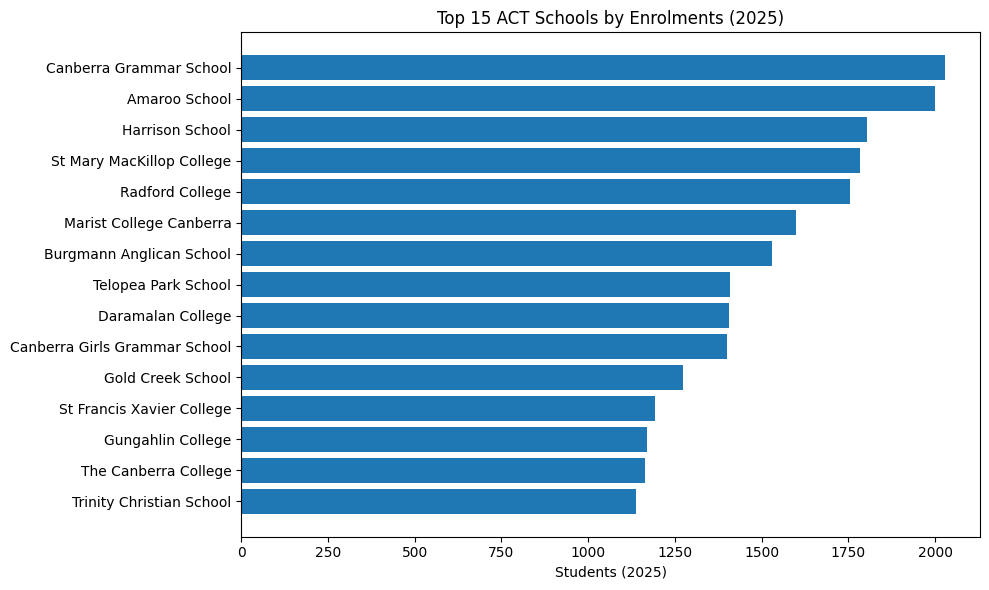

In [34]:
# ---------- Visuals ----------
# 1) Top 15 schools by enrolment (bar)
top15 = enrol_by_school.sort_values("Students", ascending=False).head(15)
plt.figure(figsize=(10,6))
plt.barh(top15["School Name"][::-1], top15["Students"][::-1])
plt.xlabel("Students (2025)")
plt.title("Top 15 ACT Schools by Enrolments (2025)")
plt.tight_layout()
plt.show()

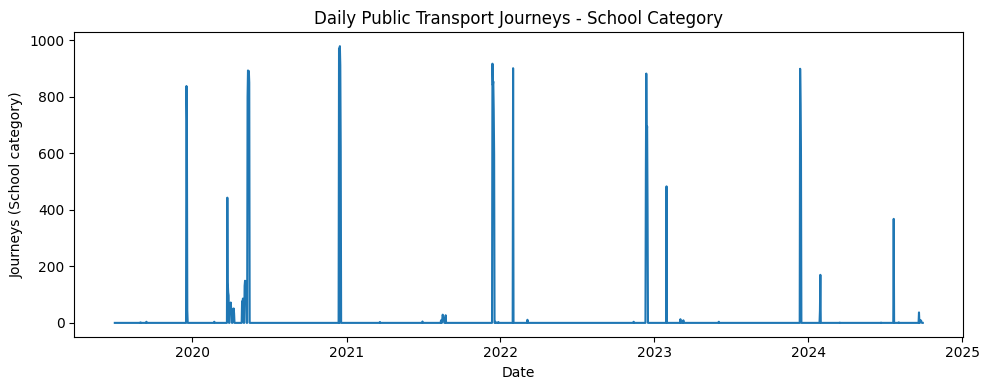

In [35]:
# 2) Daily school PT journeys over time
plt.figure(figsize=(10,4))
plt.plot(school_by_date["Date"], school_by_date["School"])
plt.xlabel("Date")
plt.ylabel("Journeys (School category)")
plt.title("Daily Public Transport Journeys - School Category")
plt.tight_layout()
plt.show()

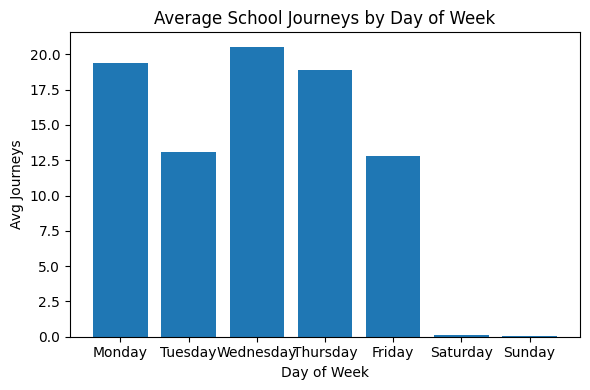

In [36]:
# 3) Average School journeys by Day of Week
plt.figure(figsize=(6,4))
plt.bar(dow_avg["dow"].astype(str), dow_avg["School"])
plt.xlabel("Day of Week")
plt.ylabel("Avg Journeys")
plt.title("Average School Journeys by Day of Week")
plt.tight_layout()
plt.show()


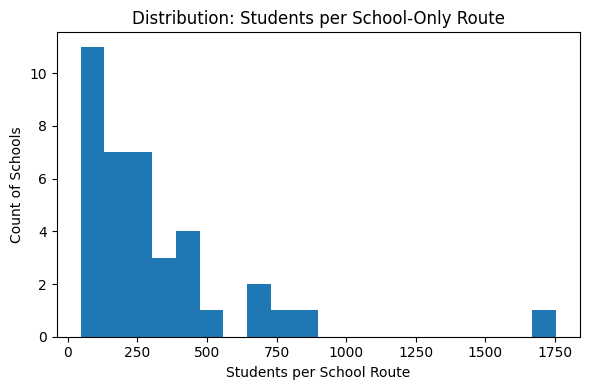

In [37]:
# 4) Students per route distribution
spr = school_summary["students_per_route"].dropna()
plt.figure(figsize=(6,4))
plt.hist(spr, bins=20)
plt.xlabel("Students per School Route")
plt.ylabel("Count of Schools")
plt.title("Distribution: Students per School-Only Route")
plt.tight_layout()
plt.show()

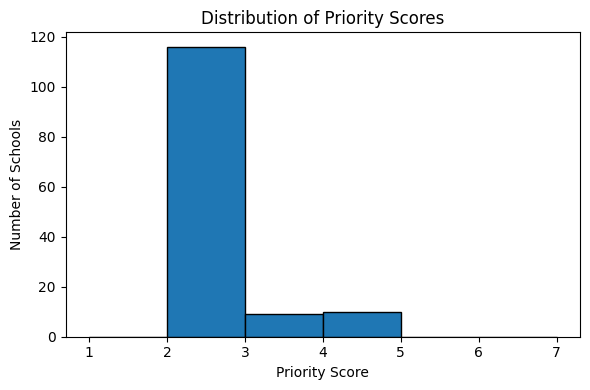

In [38]:
# 5. Histogram: Priority Score
plt.figure(figsize=(6,4))
plt.hist(school_summary["priority_score"], bins=range(1,8), edgecolor="black")
plt.xlabel("Priority Score")
plt.ylabel("Number of Schools")
plt.title("Distribution of Priority Scores")
plt.tight_layout()
plt.show()

/var/folders/wf/dm__wbb55gsf9_40cvpwfz1r0000gn/T/ipykernel_35897/3568533761.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="congestion_risk", data=school_summary, order=["Low","Medium","High","Unknown (no school-only routes)"], palette="coolwarm")


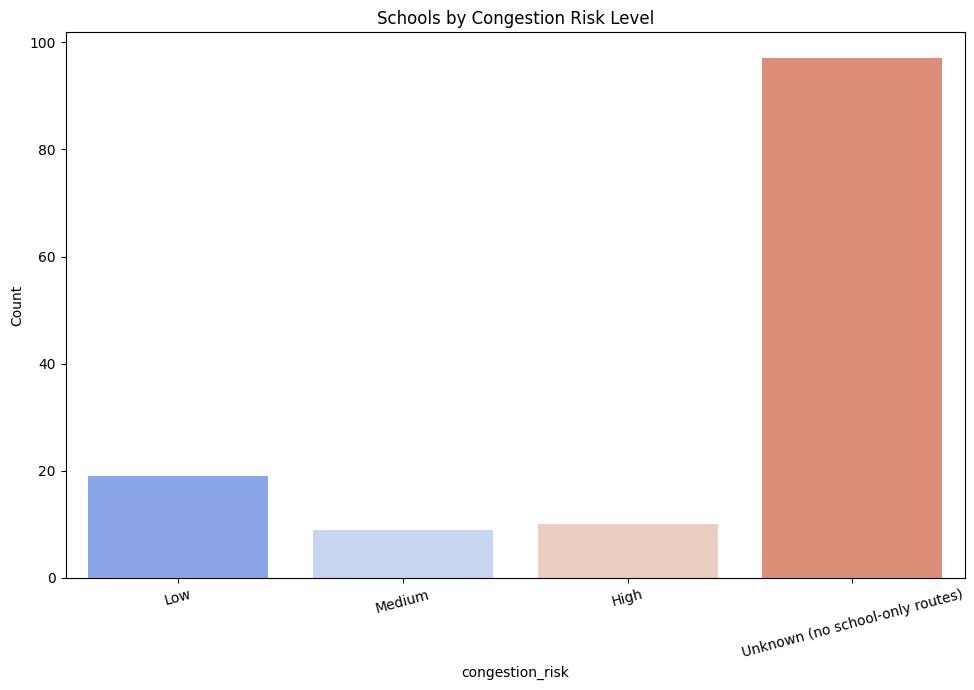

In [39]:
# 6. Schools by Congestion Risk
plt.figure(figsize=(10,7))
sns.countplot(x="congestion_risk", data=school_summary, order=["Low","Medium","High","Unknown (no school-only routes)"], palette="coolwarm")
plt.title("Schools by Congestion Risk Level")
plt.ylabel("Count")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

/var/folders/wf/dm__wbb55gsf9_40cvpwfz1r0000gn/T/ipykernel_35897/2328237382.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="pr_suitability", data=school_summary, order=["High (use nearby P&R)","Medium (signage/shuttle)","Low/Investigate (add/expand P&R)"], palette="viridis")


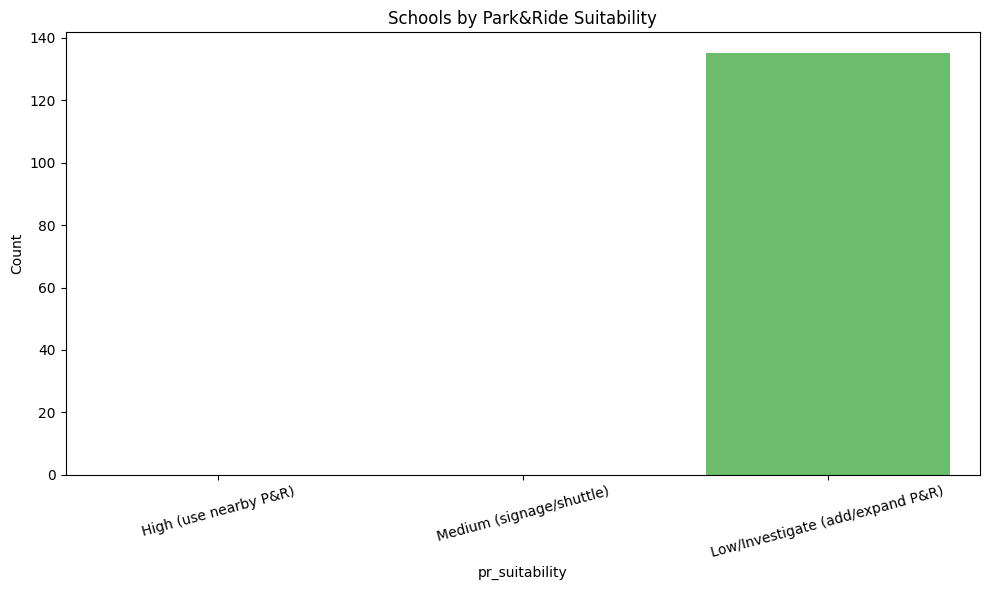

In [40]:
# 7. Schools by Park&Ride suitability
plt.figure(figsize=(10, 6))
sns.countplot(x="pr_suitability", data=school_summary, order=["High (use nearby P&R)","Medium (signage/shuttle)","Low/Investigate (add/expand P&R)"], palette="viridis")
plt.title("Schools by Park&Ride Suitability")
plt.ylabel("Count")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

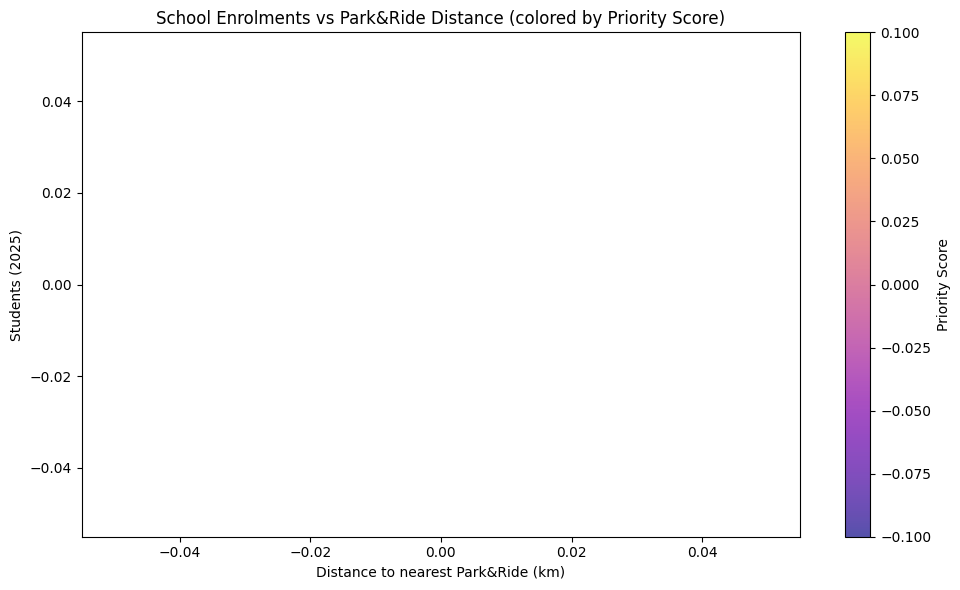

In [41]:
# 8. Scatter: Enrolments vs distance to P&R (color by priority)
plt.figure(figsize=(10, 6))
sc = plt.scatter(school_summary["pr_distance_km"], school_summary["students_2025"], c=school_summary["priority_score"], cmap="plasma", alpha=0.7, edgecolor="k")
plt.xlabel("Distance to nearest Park&Ride (km)")
plt.ylabel("Students (2025)")
plt.title("School Enrolments vs Park&Ride Distance (colored by Priority Score)")
plt.colorbar(sc,label="Priority Score")
plt.tight_layout()
plt.show()

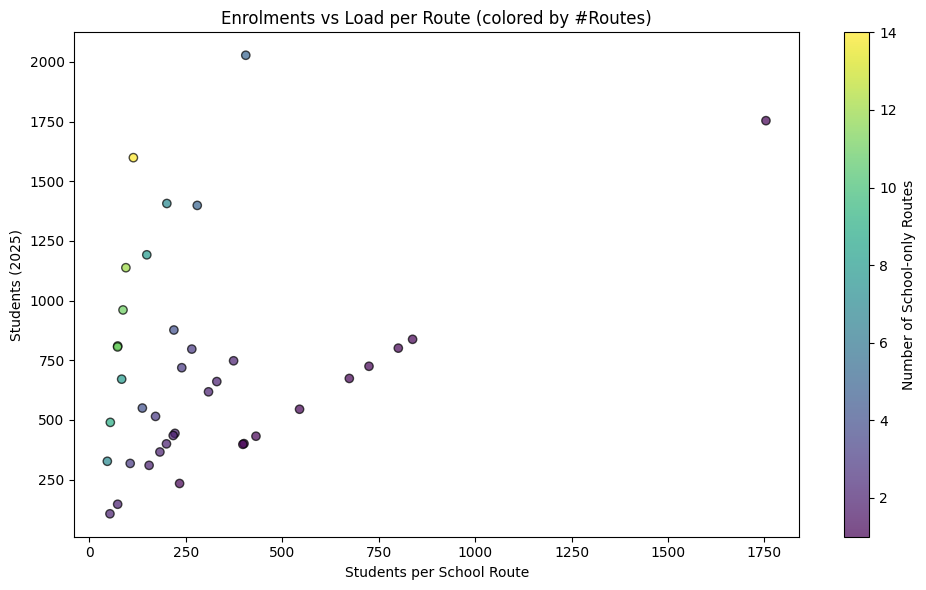

In [42]:
# 9. Scatter: Enrolments vs Students per Route (color by routes)
plt.figure(figsize=(10, 6))
sc = plt.scatter(school_summary["students_per_route"], school_summary["students_2025"], c=school_summary["num_school_routes"], cmap="viridis", alpha=0.7, edgecolor="k")
plt.xlabel("Students per School Route")
plt.ylabel("Students (2025)")
plt.title("Enrolments vs Load per Route (colored by #Routes)")
plt.colorbar(sc,label="Number of School-only Routes")
plt.tight_layout()
plt.show()


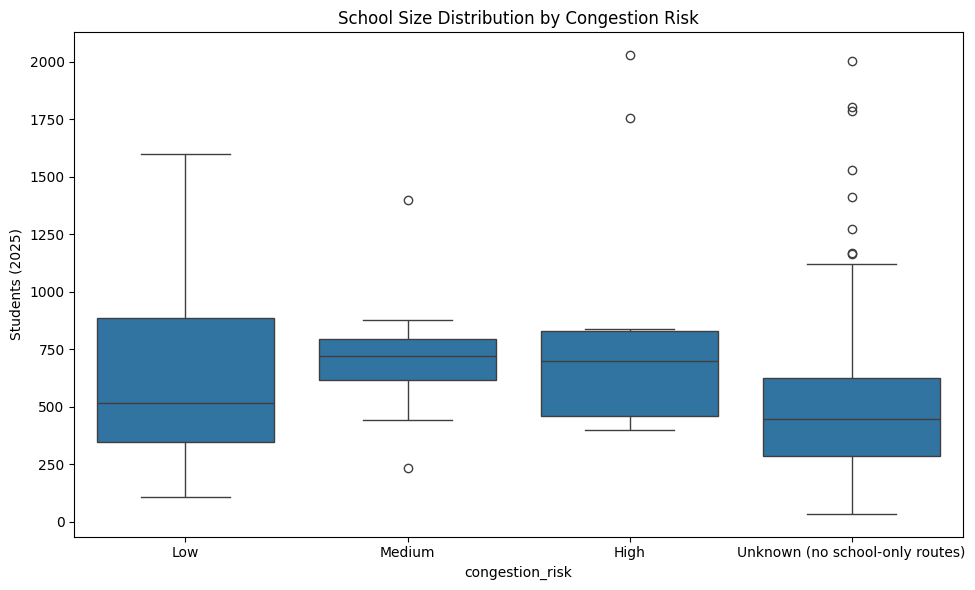

In [43]:
# 10. Boxplot: Students by Congestion Risk
plt.figure(figsize=(10, 6))
sns.boxplot(x="congestion_risk", y="students_2025", data=school_summary, order=["Low","Medium","High","Unknown (no school-only routes)"])
plt.title("School Size Distribution by Congestion Risk")
plt.ylabel("Students (2025)")
plt.tight_layout()
plt.show()

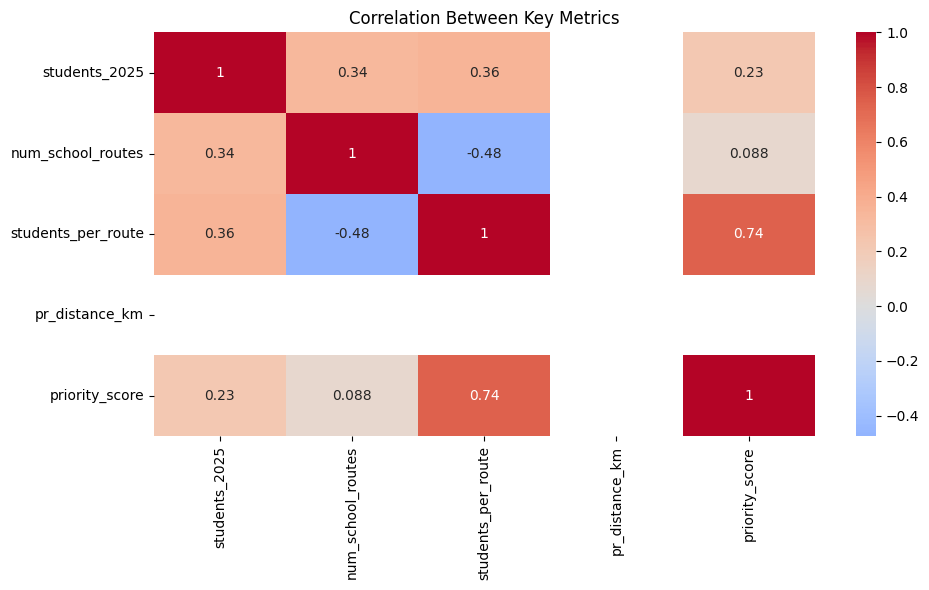

In [44]:
# 11. Correlation heatmap
plt.figure(figsize=(10, 6))
corr = school_summary[["students_2025","num_school_routes","students_per_route","pr_distance_km","priority_score"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Between Key Metrics")
plt.tight_layout()
plt.show()